In [ ]:
!pip install tensorflow
!pip install keras

100%|██████████| 10/10 [1:47:03<00:00, 642.35s/trial, best loss: 5.47379207611084]
Best Hidden Units: 32
Best Dropout Rate: 0.41840501795608215
Best Loss: 5.47379207611084
Best Validation Accuracy: 0.5768083930015564


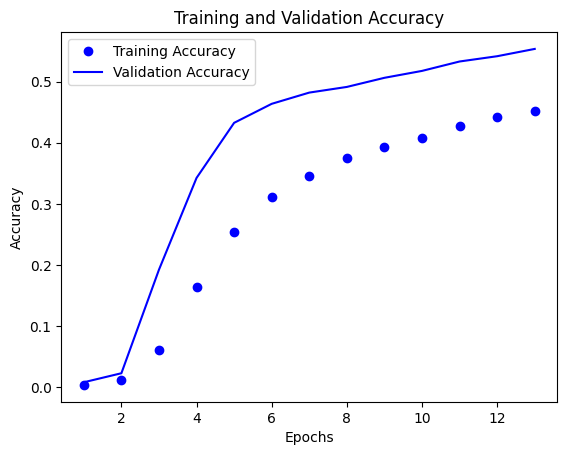

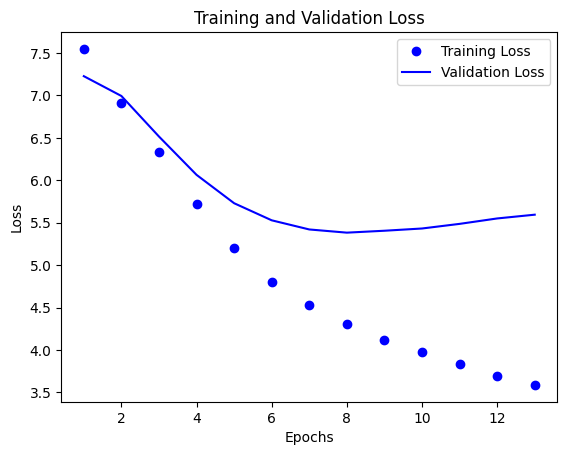

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from hyperopt import fmin, tpe, hp, Trials
import matplotlib.pyplot as plt

df = pd.read_excel('/content/Huwavie data 2021_2022.xlsx')

# Drop rows with missing values or non-textual values
df = df.dropna(subset=['message', 'created_time'])  # Replace 'text_column' and 'label_column' with the actual column names

# Convert the columns to string type
df['message'] = df['message'].astype(str)
df['created_time'] = df['created_time'].astype(str)

x = df['message'].values
y = df['created_time'].values

tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(x)
X = tokenizer.texts_to_sequences(x)
X = pad_sequences(X, maxlen=40)

dic = tokenizer.word_index

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Rest of the code remains the same...


# Define the objective function for hyperopt
def objective(params):
    model = Sequential()
    model.add(Embedding(input_dim=1000, output_dim=64, input_length=40))
    model.add(LSTM(units=params['hidden_units']))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=13, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = history.history['val_loss'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    return {'loss': val_loss, 'status': 'ok', 'accuracy': val_accuracy}

# Define the search space for hyperparameters
search_space = {
    'hidden_units': hp.choice('hidden_units', [32, 64, 128]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5)
}

# Run hyperparameter optimization using TPE algorithm
trials = Trials()
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=10, trials=trials)

# Get the best hyperparameters and their performance
best_hidden_units = [32, 64, 128][best['hidden_units']]
best_dropout_rate = best['dropout_rate']
best_loss = trials.best_trial['result']['loss']
best_accuracy = trials.best_trial['result']['accuracy']

# Print the best hyperparameters and their performance
print("Best Hidden Units:", best_hidden_units)
print("Best Dropout Rate:", best_dropout_rate)
print("Best Loss:", best_loss)
print("Best Validation Accuracy:", best_accuracy)

# Retrieve the final model's training history
best_model = Sequential()
best_model.add(Embedding(input_dim=1000, output_dim=64, input_length=40))
best_model.add(LSTM(units=best_hidden_units))
best_model.add(Dropout(best_dropout_rate))
best_model.add(Dense(units=num_classes, activation='softmax'))
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
best_history = best_model.fit(X_train, y_train, epochs=13, batch_size=32, validation_data=(X_test, y_test), verbose=0)

acc = best_history.history['accuracy']
val_acc = best_history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
